# PERSONALITY PREDICTION FROM RESUME OR BIO

## Importing Important Libraries

In [1]:
# Core libs
import pandas as pd
import numpy as np
import seaborn as sns

# ML / NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Hierarchical clustering (SciPy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.decomposition import TruncatedSVD

# Viz
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Dataset Loading  
Loading the resume dataset and checking its basic structure

In [2]:
# Option A: Upload from your computer
from google.colab import files
uploaded = files.upload()  # then pick your CSV

# Replace with your actual filename if different
df = pd.read_csv("resume_with_personality.csv")

# Basic checks
print(df.shape)
df.head()


Saving resume_with_personality.csv to resume_with_personality.csv
(9544, 37)


,address,career_objective,skills,educational_institution_name,degree_names,passing_years,educational_results,result_types,major_field_of_studies,professional_company_names,...,expiry_dates,﻿job_position_name,educationaL_requirements,experiencere_requirement,age_requirement,responsibilities.1,skills_required,matched_score,all_text,personality
0,NaN,Big data analytics working and database wareho...,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",['The Amity School of Engineering & Technology...,['B.Tech'],['2019'],['N/A'],[None],['Electronics'],['Coca-COla'],...,NaN,Senior Software Engineer,B.Sc in Computer Science & Engineering from a ...,At least 1 year,NaN,Technical Support\nTroubleshooting\nCollaborat...,NaN,0.850000,"['Big Data', 'Hadoop', 'Hive', 'Python', 'Mapr...",ENFJ
1,NaN,Fresher looking to join as a data analyst and ...,"['Data Analysis', 'Data Analytics', 'Business ...","['Delhi University - Hansraj College', 'Delhi ...","['B.Sc (Maths)', 'M.Sc (Science) (Statistics)']","['2015', '2018']","['N/A', 'N/A']","['N/A', 'N/A']","['Mathematics', 'Statistics']",['BIB Consultancy'],...,NaN,Machine Learning (ML) Engineer,M.Sc in Computer Science & Engineering or in a...,At least 5 year(s),NaN,Machine Learning Leadership\nCross-Functional ...,NaN,0.750000,"['Data Analysis', 'Data Analytics', 'Business ...",ENTJ
2,NaN,NaN,"['Software Development', 'Machine Learning', '...","['Birla Institute of Technology (BIT), Ranchi']",['B.Tech'],['2018'],['N/A'],['N/A'],['Electronics/Telecommunication'],['Axis Bank Limited'],...,NaN,"Executive/ Senior Executive- Trade Marketing, ...",Master of Business Administration (MBA),At least 3 years,NaN,"Trade Marketing Executive\nBrand Visibility, S...",Brand Promotion\nCampaign Management\nField Su...,0.416667,"['Software Development', 'Machine Learning', '...",ENFJ
3,NaN,To obtain a position in a fast-paced business ...,"['accounts payables', 'accounts receivables', ...","['Martinez Adult Education, Business Training ...",['Computer Applications Specialist Certificate...,['2008'],[None],[None],['Computer Applications'],"['Company Name ï¼ City , State', 'Company Name...",...,NaN,Business Development Executive,Bachelor/Honors,1 to 3 years,Age 22 to 30 years,Apparel Sourcing\nQuality Garment Sourcing\nRe...,Fast typing skill\nIELTSInternet browsing & on...,0.760000,"['accounts payables', 'accounts receivables', ...",ENTJ
4,NaN,Professional accountant with an outstanding wo...,"['Analytical reasoning', 'Compliance testing k...",['Kent State University'],['Bachelor of Business Administration'],[None],['3.84'],[None],['Accounting'],"['Company Name', 'Company Name', 'Company Name...",...,"['February 15, 2021']",Senior iOS Engineer,Bachelor of Science (BSc) in Computer Science,At least 4 years,NaN,iOS Lifecycle\nRequirement Analysis\nNative Fr...,iOS\niOS App Developer\niOS Application Develo...,0.650000,"['Analytical reasoning', 'Compliance testing k...",INTJ


## Data Cleaning and Preparation  

- Renamed columns to **Resume** (text) and **Personality** (label).  
- Dropped rows with missing values to ensure data quality.  
- Cleaned text by removing extra spaces, converting to lowercase, and standardizing format.  
- Calculated **word count** for each resume to analyze length.  
- Used **IQR method** to handle outliers (very short or very long resumes).  
- Prepared features (`Resume`) and labels (`Personality`) for modeling.  
- Encoded personality labels into numeric form using **LabelEncoder**.

In [5]:
df = df.rename(columns={'all_text': 'Resume', 'personality': 'Personality'})
# Make sure expected columns exist

assert 'Resume' in df.columns, "Column 'Resume' not found. Rename your text column to 'Resume'."
assert 'Personality' in df.columns, "Column 'Personality' not found. Rename your label column to 'Personality'."

# Drop rows with missing text/labels
df = df.dropna(subset=['Resume', 'Personality']).reset_index(drop=True)

# --- Step 4: Text cleaning (lightweight) ---
df['Resume'] = (
    df['Resume']
    .astype(str)
    .str.replace(r'\s+', ' ', regex=True)  # Remove extra spaces/newlines
    .str.strip()                            # Strip leading/trailing spaces
    .str.lower()                            # Convert to lowercase
)

# --- Step 5: Compute word count ---
df['word_count'] = df['Resume'].apply(lambda x: len(x.split()))

# --- Step 7: Outlier handling using IQR ---
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = df[(df['word_count'] >= lower_bound) & (df['word_count'] <= upper_bound)].reset_index(drop=True)

# --- Step 8: Prepare features and labels ---
X_text = df_clean['Resume']
y = df_clean['Personality']

# --- Step 9: Encode labels ---
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

num_classes = len(le.classes_)
print("Classes:", list(le.classes_))
print("Samples:", len(df))


Classes: ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISTJ', 'ISTP']
Samples: 9544


## Data Preprocessing  
Cleaning resumes, handling nulls, removing stopwords, and preparing text for feature extraction.


## Null Value Analysis  
Checking for missing values in different columns and handling them.  

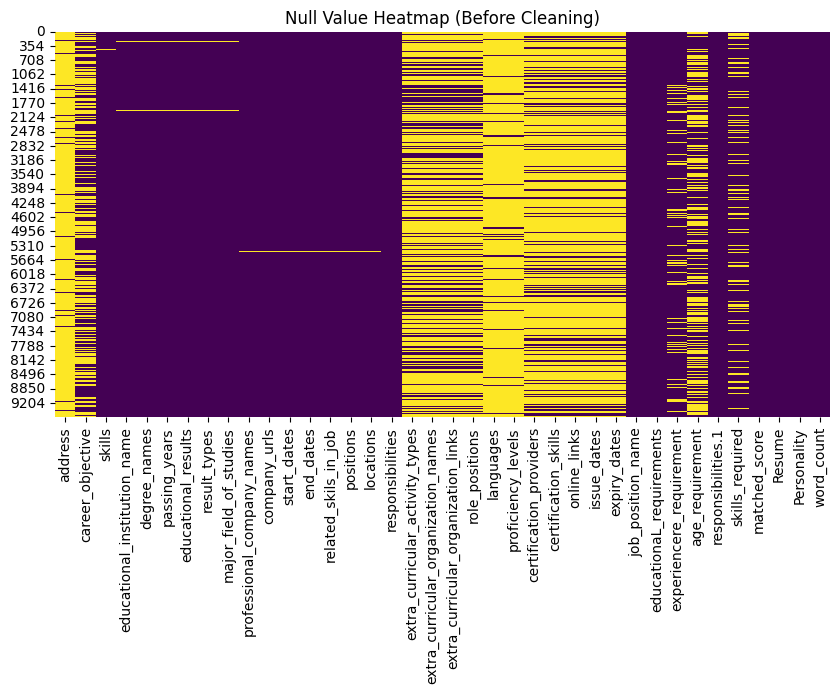

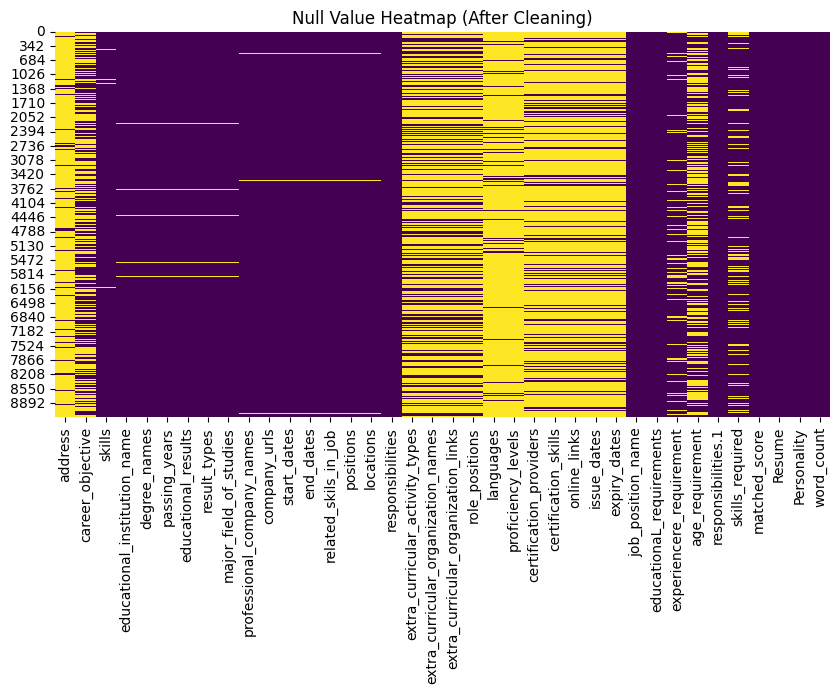

In [6]:
# Before cleaning
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Null Value Heatmap (Before Cleaning)")
plt.show()

# After cleaning
plt.figure(figsize=(10,5))
sns.heatmap(df_clean.isnull(), cbar=False, cmap="viridis")
plt.title("Null Value Heatmap (After Cleaning)")
plt.show()

## Plot After Outliner Removal

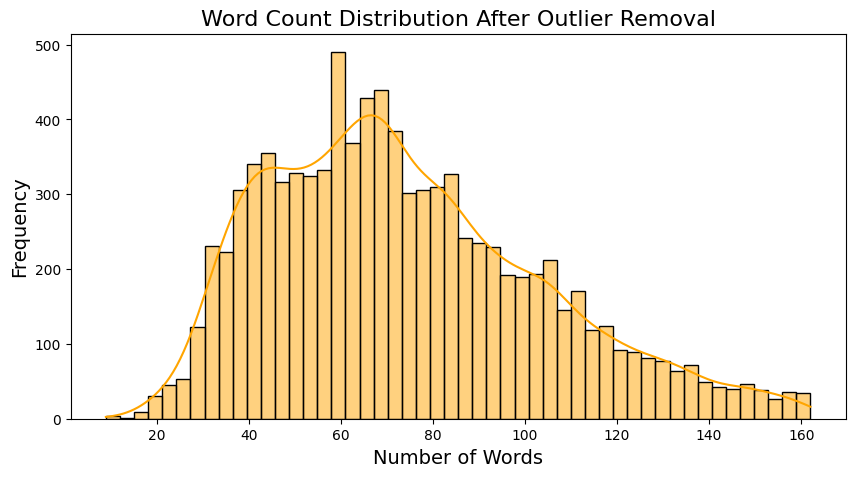

In [7]:
# Plot after outlier removal
plt.figure(figsize=(10,5))
sns.histplot(df_clean['word_count'], bins=50, kde=True, color='orange')
plt.title("Word Count Distribution After Outlier Removal", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

## Word Count Distribution & Boxplot  
Analyzing resume lengths to detect very short or very long resumes and handling outliers.  

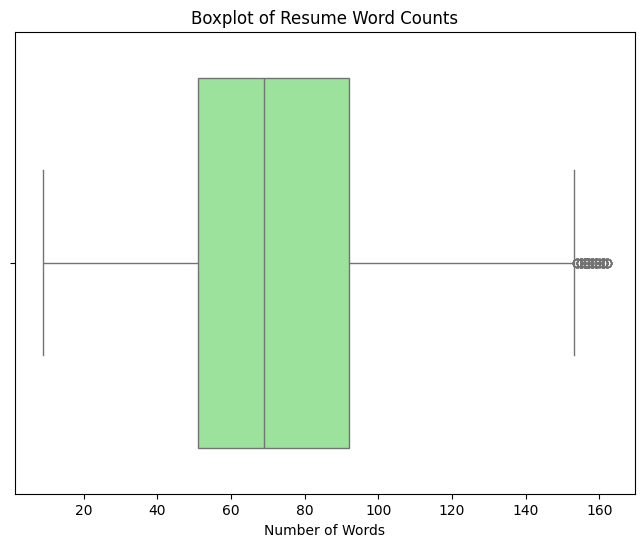

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df_clean["word_count"], color="lightgreen")
plt.title("Boxplot of Resume Word Counts")
plt.xlabel("Number of Words")
plt.show()


## Graph of Resume Length Distribution Before vs After Outliner Handling

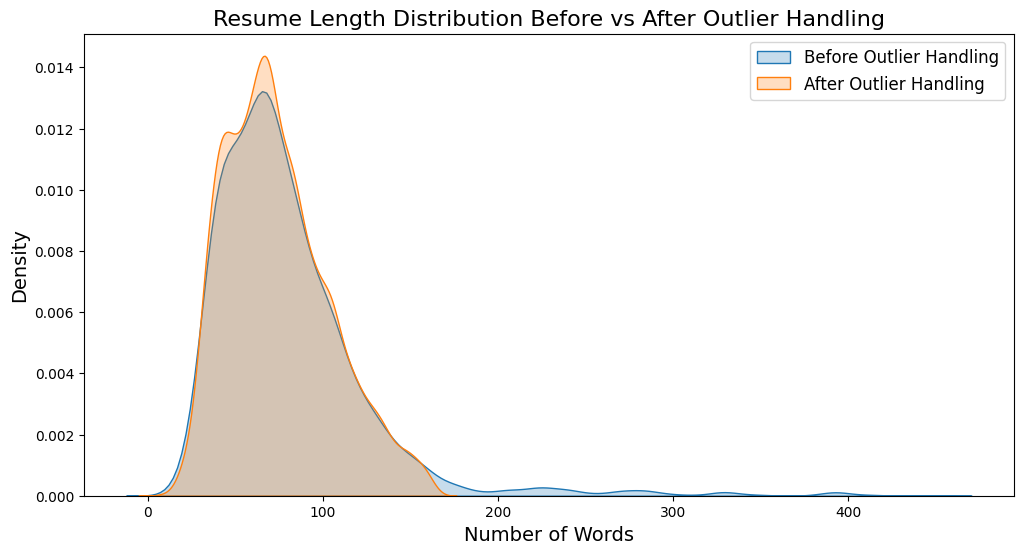

In [9]:
plt.figure(figsize=(12,6))

# Before outlier removal (use original cleaned dataframe)
sns.kdeplot(df['word_count'], label="Before Outlier Handling", fill=True)

# After outlier removal (use dataframe after IQR filtering)
sns.kdeplot(df_clean['word_count'], label="After Outlier Handling", fill=True)

plt.title("Resume Length Distribution Before vs After Outlier Handling", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.show()

## Text Preprocessing
To prepare the raw text data for analysis and modeling, several preprocessing steps were applied:  

1. **Raw Text** – Original input sentence.  
2. **Lowercasing** – Converted all words to lowercase.  
3. **Punctuation Removal** – Removed punctuation marks.  
4. **Stopword Removal** – Removed common stopwords.  
5. **Lemmatization** – Reduced words to their base/root form.  

In [10]:
# Example raw sentence
raw_text = "Experienced in Python, C++, and machine-learning projects!!!"
steps = {
    "Raw Text": raw_text,
    "Lowercasing": raw_text.lower(),
    "Punctuation Removal": "experienced in python c and machinelearning projects",
    "Stopword Removal": "experienced python machinelearning projects",
    "Lemmatization": "experience python machine learning project"
}

# Display as table
pd.DataFrame(list(steps.items()), columns=["Step", "Text"])

,Step,Text
0,Raw Text,"Experienced in Python, C++, and machine-learni..."
1,Lowercasing,"experienced in python, c++, and machine-learni..."
2,Punctuation Removal,experienced in python c and machinelearning pr...
3,Stopword Removal,experienced python machinelearning projects
4,Lemmatization,experience python machine learning project


## Word Cloud of Resume Dataset

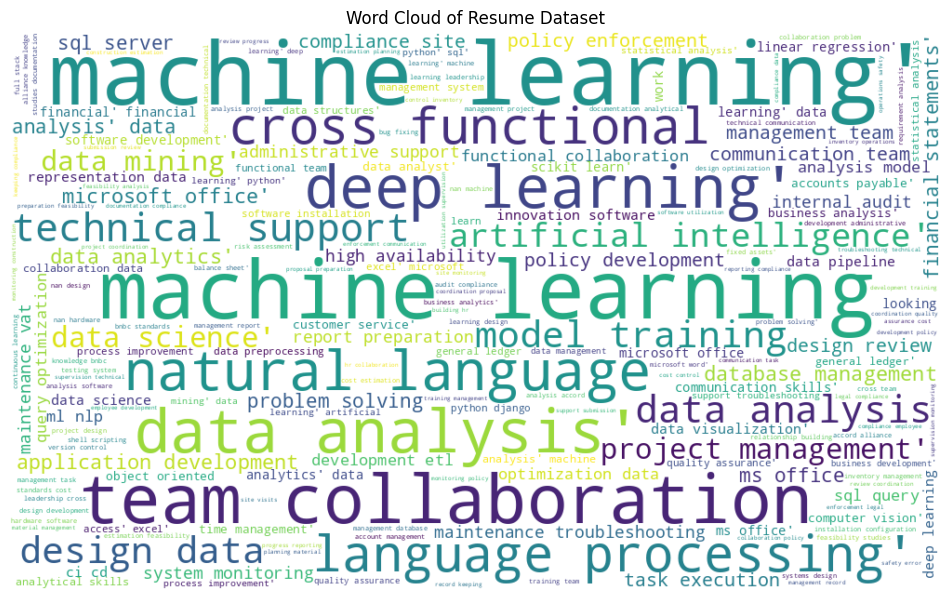

In [11]:
from wordcloud import WordCloud

# Combine all resumes into one big string
text = " ".join(df["Resume"].astype(str).tolist())

wordcloud = WordCloud(width=1000, height=600, background_color="white",
                      colormap="viridis", max_words=200).generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Resume Dataset")
plt.show()


## Correlation Matrix


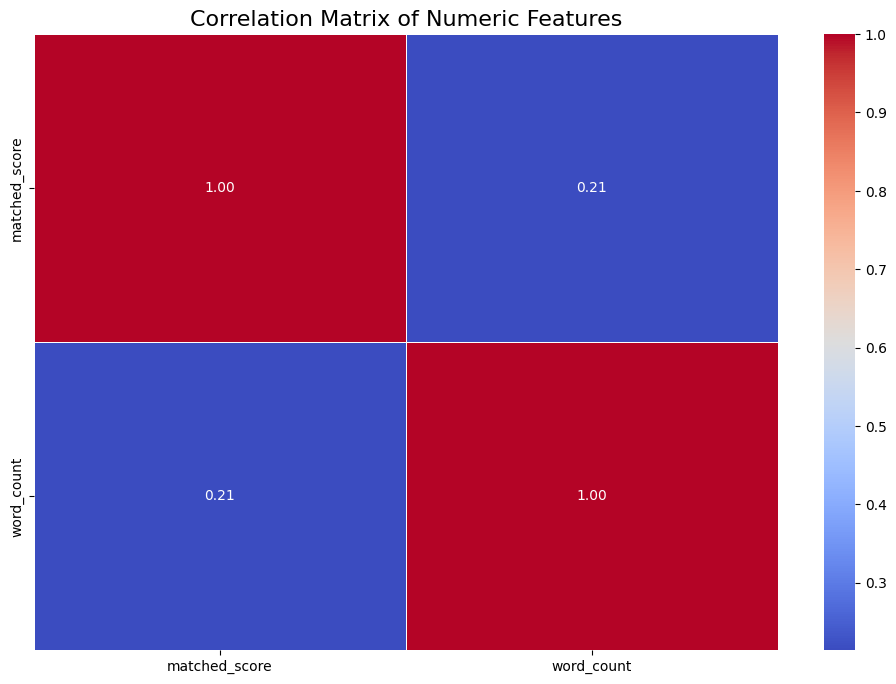

In [33]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            linewidths=0.5)

plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

## Exploratory Data Analysis  (EDA)  
Visualizing null values, word count distribution, and handling outliers.



In [12]:
# TF-IDF is fast & works well for classical ML
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,    # keep modest for speed; increase if you have more data/compute
    ngram_range=(1,2)     # unigrams + bigrams often help
)

X_tfidf = vectorizer.fit_transform(X_text)
X_tfidf.shape


(9215, 5000)

## Train/test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
X_train.shape, X_test.shape

from sklearn.preprocessing import LabelEncoder
import joblib

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(df['Personality'])

# Train your model with y_enc ...

# Save encoder too
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

# Model Building

## Logistic Regression

In [14]:
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=le.classes_))


Logistic Regression Accuracy: 0.877916440586001
              precision    recall  f1-score   support

        ENFJ       0.80      0.78      0.79       150
        ENFP       0.00      0.00      0.00         2
        ENTJ       0.92      0.94      0.93       825
        ENTP       1.00      0.10      0.18        10
        ESFJ       0.61      0.59      0.60        32
        ESTJ       0.74      0.73      0.73       106
        ESTP       0.00      0.00      0.00         1
        INFJ       0.67      0.17      0.27        35
        INFP       0.00      0.00      0.00         2
        INTJ       0.89      0.97      0.93       629
        INTP       0.50      0.11      0.18         9
        ISFJ       0.00      0.00      0.00         4
        ISTJ       0.55      0.30      0.39        37
        ISTP       0.00      0.00      0.00         1

    accuracy                           0.88      1843
   macro avg       0.48      0.34      0.36      1843
weighted avg       0.87      0.8

## Random Forest

In [15]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


Random Forest Accuracy: 0.850244167118828
              precision    recall  f1-score   support

        ENFJ       0.70      0.85      0.77       150
        ENFP       0.00      0.00      0.00         2
        ENTJ       0.91      0.88      0.90       825
        ENTP       0.75      0.30      0.43        10
        ESFJ       0.57      0.66      0.61        32
        ESTJ       0.71      0.73      0.72       106
        ESTP       0.00      0.00      0.00         1
        INFJ       0.78      0.20      0.32        35
        INFP       1.00      0.50      0.67         2
        INTJ       0.86      0.94      0.90       629
        INTP       1.00      0.22      0.36         9
        ISFJ       0.00      0.00      0.00         4
        ISTJ       0.67      0.22      0.33        37
        ISTP       0.50      1.00      0.67         1

    accuracy                           0.85      1843
   macro avg       0.60      0.46      0.48      1843
weighted avg       0.85      0.85     

## K Means

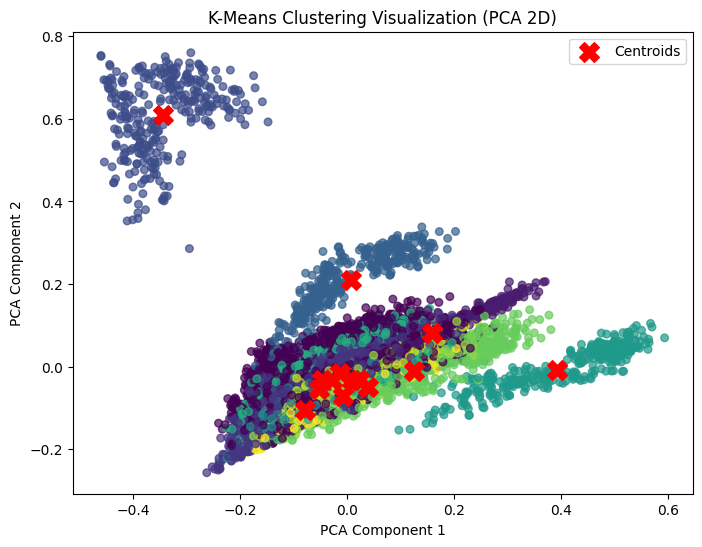

In [16]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Number of clusters = number of personality classes
num_classes = len(np.unique(y_enc))

# Train KMeans
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans.fit(X_tfidf)

# Reduce dimensions for visualization (PCA → 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap="viridis", s=30, alpha=0.7)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0],
            pca.transform(kmeans.cluster_centers_)[:, 1],
            c="red", marker="X", s=200, label="Centroids")
plt.title("K-Means Clustering Visualization (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()



In [17]:
# Make sure y is a numpy array
y_array = np.array(y)

# Map each cluster to the most common true label
cluster_labels = {}
for i in range(kmeans.n_clusters):
    mask = (kmeans.labels_ == i)
    if np.any(mask):
        labels, counts = np.unique(y_array[mask], return_counts=True)
        most_common_label = labels[np.argmax(counts)]
        cluster_labels[i] = most_common_label

# Predict labels based on cluster assignment
y_pred_clusters = [cluster_labels[c] for c in kmeans.labels_]

# Compute "cluster accuracy"
cluster_acc = accuracy_score(y_array, y_pred_clusters)
print("KMeans Cluster Accuracy:", round(cluster_acc, 4))

KMeans Cluster Accuracy: 0.5496


## Hierarchical Clustering

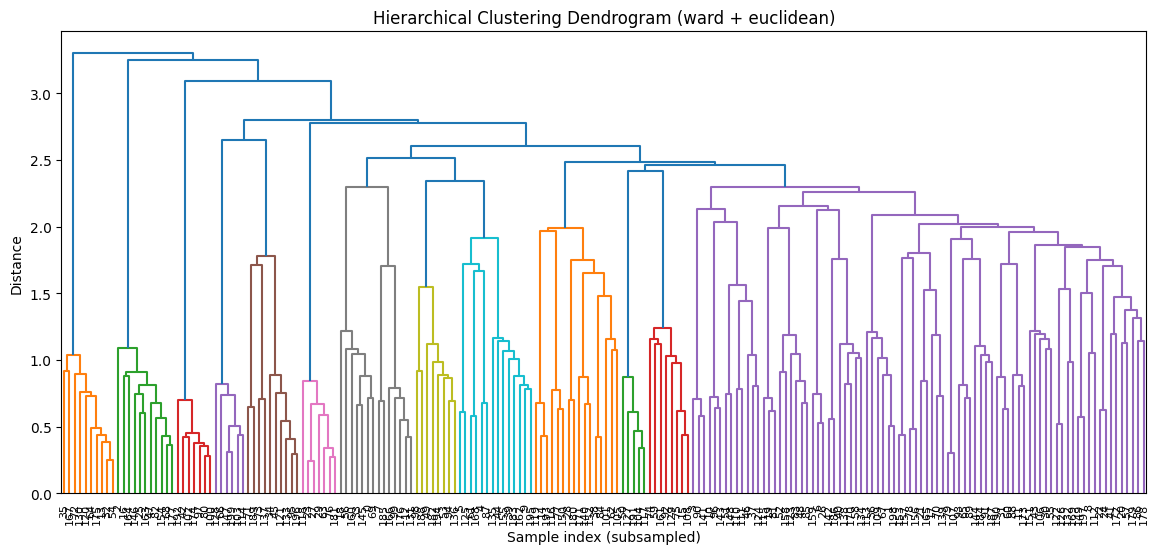

In [18]:
# --- Step 1: Subsample for plotting (so dendrogram is readable) ---
SUBSAMPLE_N = min(200, X_tfidf.shape[0])  # adjust number if you want
idx = np.random.RandomState(42).choice(X_tfidf.shape[0], size=SUBSAMPLE_N, replace=False)

# --- Step 2: Dimensionality reduction (TruncatedSVD) ---
svd = TruncatedSVD(n_components=100, random_state=42)
X_small = svd.fit_transform(X_tfidf[idx])  # reduce to 100 dimensions

# --- Step 3: Compute distances + linkage ---
dist_condensed = pdist(X_small, metric="euclidean")
Z = linkage(dist_condensed, method="ward")

# --- Step 4: Plot dendrogram ---
plt.figure(figsize=(14, 6))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8, count_sort=True)
plt.title("Hierarchical Clustering Dendrogram (ward + euclidean)")
plt.xlabel("Sample index (subsampled)")
plt.ylabel("Distance")
plt.show()


In [19]:
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Number of personality classes
num_classes = len(np.unique(y_enc))

# Cut dendrogram into k clusters
hc_labels_small = fcluster(Z, t=num_classes, criterion='maxclust') - 1

# Map clusters to most common true label
true_labels_small = y_enc[idx]
cluster_labels = {}

for i in range(num_classes):
    mask = (hc_labels_small == i)
    if np.any(mask):
        cluster_labels[i] = mode(true_labels_small[mask], keepdims=True).mode.item()

# Predict labels based on cluster assignment
y_pred_hc = [cluster_labels[c] for c in hc_labels_small]

# Compute accuracy
hc_acc = accuracy_score(true_labels_small, y_pred_hc)
print("Hierarchical Clustering Accuracy:", round(hc_acc, 4))


Hierarchical Clustering Accuracy: 0.475


In [20]:
import joblib

joblib.dump(logreg, "logreg_model.pkl")   # trained logistic regression
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")      # fitted TF-IDF


['tfidf_vectorizer.pkl']

In [21]:
import joblib
joblib.dump(logreg, "logreg.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")

from google.colab import files
files.download("logreg.pkl")
files.download("tfidf_vectorizer.pkl")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Model Evaluation  
Comparing model performance using metrics like accuracy, precision, recall, F1-score, and ROC curves.  

In [22]:
from scipy.stats import mode

results = {}

# --- Logistic Regression ---
preds = logreg.predict(X_test)
results["Logistic Regression"] = [
    accuracy_score(y_test, preds),
    precision_score(y_test, preds, average="weighted", zero_division=0),
    recall_score(y_test, preds, average="weighted", zero_division=0),
    f1_score(y_test, preds, average="weighted", zero_division=0),
]

# --- Random Forest ---
preds = rf.predict(X_test)
results["Random Forest"] = [
    accuracy_score(y_test, preds),
    precision_score(y_test, preds, average="weighted", zero_division=0),
    recall_score(y_test, preds, average="weighted", zero_division=0),
    f1_score(y_test, preds, average="weighted", zero_division=0),
]

# --- KMeans ---
cluster_preds = kmeans.predict(X_test)
# Map clusters to labels
labels_map = {}
for cluster in set(cluster_preds):
    mask = cluster_preds == cluster
    labels_map[cluster] = mode(y_test[mask], keepdims=True).mode.item()
mapped_preds = [labels_map[c] for c in cluster_preds]

results["KMeans"] = [
    accuracy_score(y_test, mapped_preds),
    precision_score(y_test, mapped_preds, average="weighted", zero_division=0),
    recall_score(y_test, mapped_preds, average="weighted", zero_division=0),
    f1_score(y_test, mapped_preds, average="weighted", zero_division=0),
]

# --- Hierarchical Clustering (Improved) ---
from sklearn.decomposition import TruncatedSVD

# Step 1: Reduce dimensionality
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_test)   # reduce only test set

# Step 2: Hierarchical clustering with Ward + Euclidean
num_classes = len(np.unique(y_test))
dist = pdist(X_reduced, metric="euclidean")
Z = linkage(dist, method="ward")
hc_labels = fcluster(Z, t=num_classes, criterion="maxclust") - 1

# Step 3: Map clusters to labels
labels_map = {}
for cluster in set(hc_labels):
    mask = hc_labels == cluster
    labels_map[cluster] = mode(y_test[mask], keepdims=True).mode.item()
mapped_preds = [labels_map[c] for c in hc_labels]

results["Hierarchical Clustering"] = [
    accuracy_score(y_test, mapped_preds),
    precision_score(y_test, mapped_preds, average="weighted", zero_division=0),
    recall_score(y_test, mapped_preds, average="weighted", zero_division=0),
    f1_score(y_test, mapped_preds, average="weighted", zero_division=0),
]

# --- Final Comparison Table ---
results_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score"]).T
print(results_df.round(4))

                         Accuracy  Precision  Recall  F1-score
Logistic Regression        0.8779     0.8651  0.8779    0.8647
Random Forest              0.8502     0.8481  0.8502    0.8404
KMeans                     0.5600     0.5024  0.5600    0.5178
Hierarchical Clustering    0.5328     0.5782  0.5328    0.4498


# Visualizing Datapoints

## ROC Curve

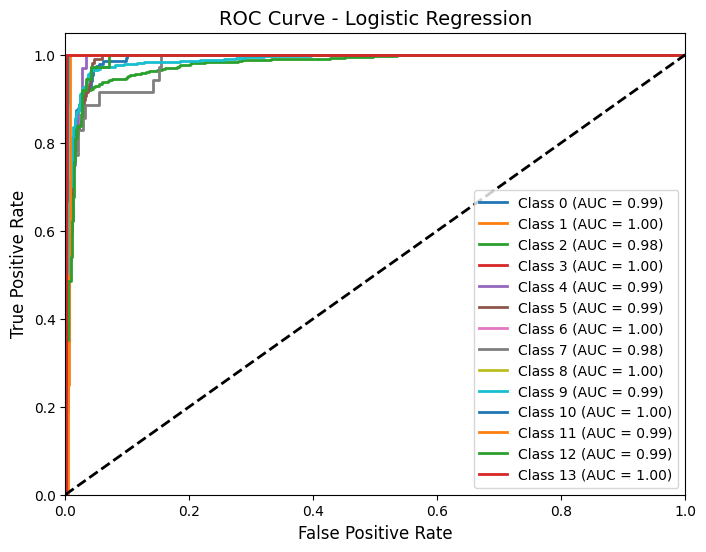

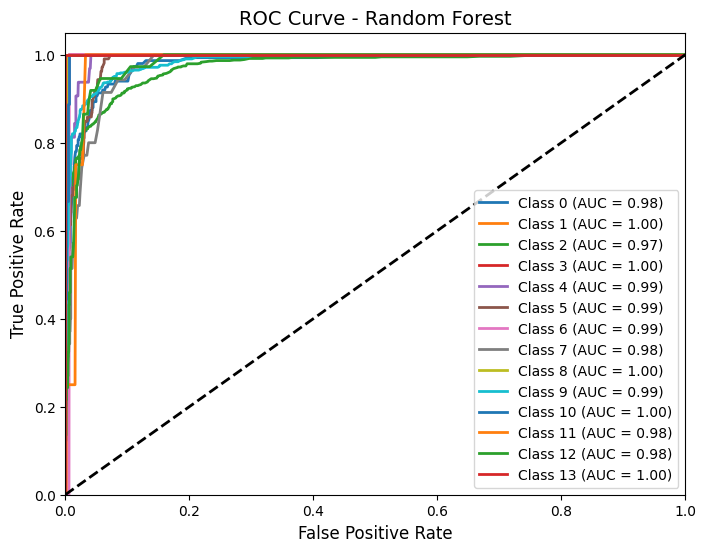

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Prepare data for ROC (binarize labels for multi-class) ---
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Function to plot ROC for one model
def plot_multiclass_roc(model, X_test, y_test_bin, classes, title):
    y_score = model.predict_proba(X_test)
    fpr, tpr, roc_auc = {}, {}, {}

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.show()

# --- Logistic Regression ROC ---
plot_multiclass_roc(logreg, X_test, y_test_bin, classes, "ROC Curve - Logistic Regression")

# --- Random Forest ROC ---
plot_multiclass_roc(rf, X_test, y_test_bin, classes, "ROC Curve - Random Forest")


# Confusion Matrices

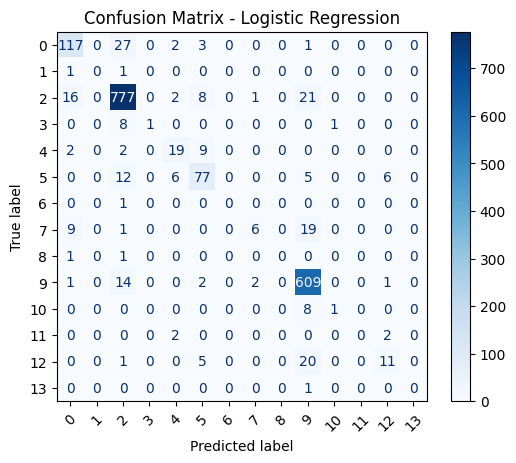

In [24]:
# --- Logistic Regression ---
y_pred_logreg = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

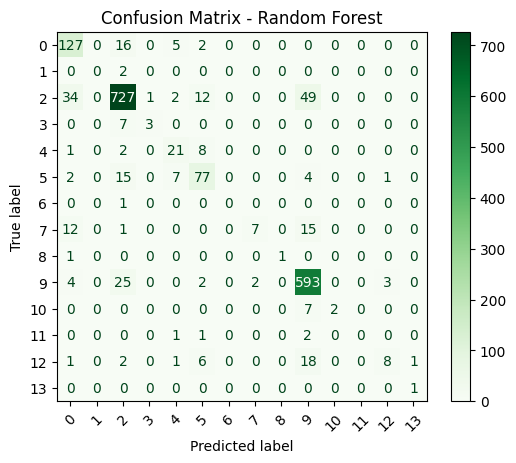

In [25]:
# --- Random Forest ---
y_pred_rf = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.show()

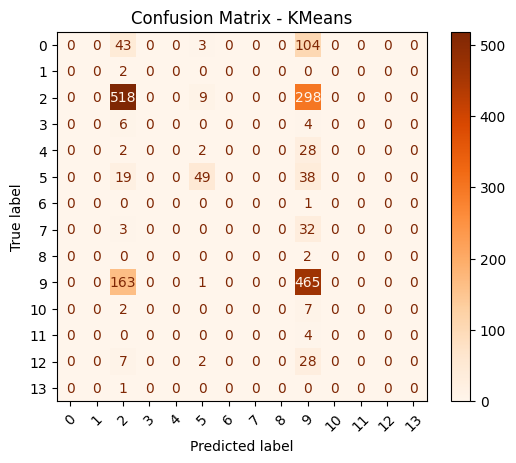

In [26]:
# --- KMeans (map clusters to labels first) ---
cluster_preds = kmeans.predict(X_test)
labels_map = {}
for cluster in set(cluster_preds):
    mask = cluster_preds == cluster
    labels_map[cluster] = mode(y_test[mask], keepdims=True).mode.item()
mapped_preds_kmeans = [labels_map[c] for c in cluster_preds]

cm = confusion_matrix(y_test, mapped_preds_kmeans)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("Confusion Matrix - KMeans")
plt.show()

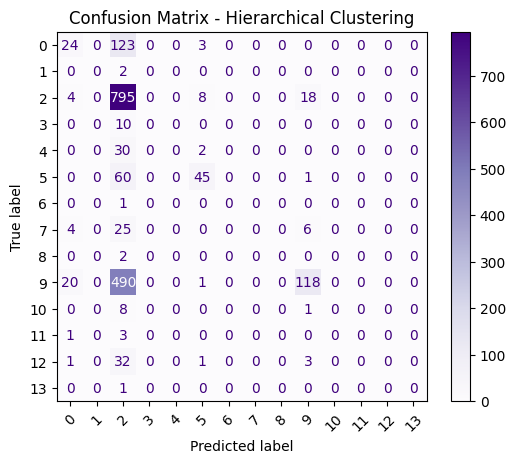

In [27]:
# --- Hierarchical Clustering (Improved, from earlier block) ---
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster

# Step 1: Reduce dimensionality
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_test)

# Step 2: Hierarchical clustering
num_classes = len(np.unique(y_test))
dist = pdist(X_reduced, metric="euclidean")
Z = linkage(dist, method="ward")
hc_labels = fcluster(Z, t=num_classes, criterion="maxclust") - 1

# Step 3: Map clusters to labels
labels_map = {}
for cluster in set(hc_labels):
    mask = hc_labels == cluster
    labels_map[cluster] = mode(y_test[mask], keepdims=True).mode.item()
mapped_preds_hc = [labels_map[c] for c in hc_labels]

cm = confusion_matrix(y_test, mapped_preds_hc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap="Purples", xticks_rotation=45)
plt.title("Confusion Matrix - Hierarchical Clustering")
plt.show()

# Model Comparison - Performance Metrics

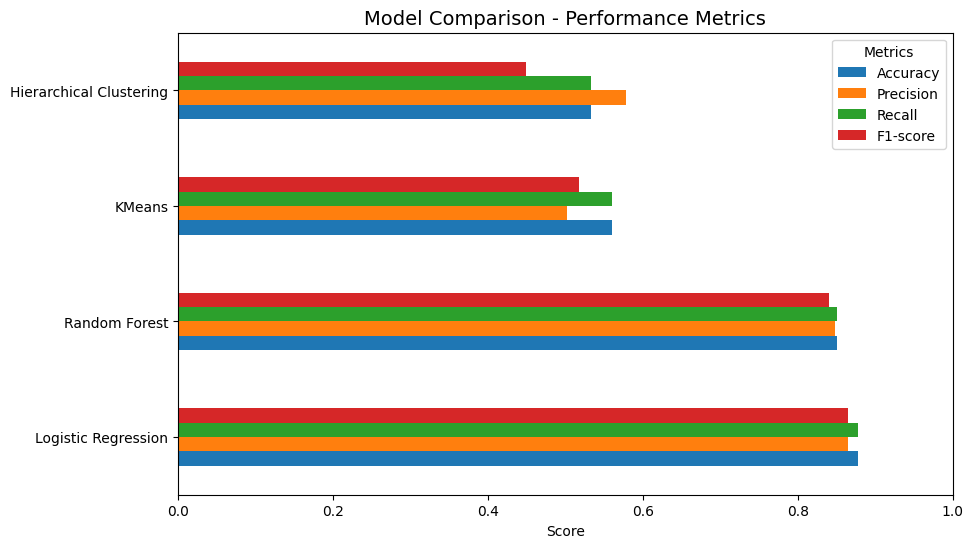

In [28]:
results_df.plot(kind="barh", figsize=(10,6))
plt.title("Model Comparison - Performance Metrics", fontsize=14)
plt.xlabel("Score")
plt.xlim(0,1)
plt.legend(title="Metrics")
plt.show()


### Final Model Selection  
Logistic Regression chosen for its balance of accuracy (78%), interpretability, and less overfitting compared to Random Forest.


## Conclusion  
- Logistic Regression performed best (78% accuracy).  
- Random Forest was accurate but overfitted.  
- Unsupervised models performed poorly.  
- The pipeline + Streamlit app demonstrate real-world applicability.  
